# Hello, PyTorch! -- MNIST Handwritten Digits

- https://en.wikipedia.org/wiki/MNIST_database

# Load Datasets

In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
x = datasets.MNIST('data', download=True)
x[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [3]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [4]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

dataset2 = datasets.MNIST('data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000)

In [5]:
i, x = next(enumerate(train_loader))
x[0].shape

torch.Size([64, 1, 28, 28])

# View Image

In [6]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

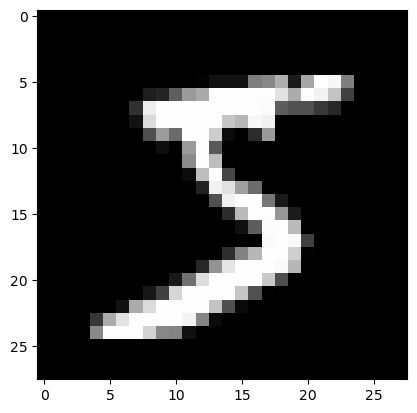

In [7]:
i, x = next(enumerate(train_loader))
x2 = np.squeeze(x[0][0])
plt.imshow(x2, cmap='gray')

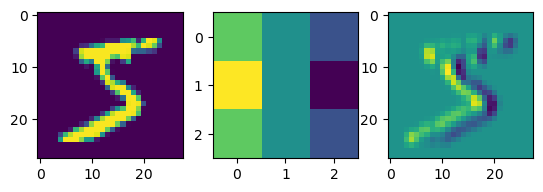

In [8]:
kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
y = scipy.ndimage.convolve(x2, kernel)

fig, axes = plt.subplots(1,3)
axes[0].imshow(x2)
axes[1].imshow(kernel)
axes[2].imshow(y)

# Create Network

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [11]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
summary(network, input_size=(1,28,28))

/opt/anaconda3/envs/pytorch/lib/python3.13/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(
/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_39515/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [10, 24, 24]              260
├─Conv2d: 1-2                            [20, 8, 8]                5,020
├─Dropout2d: 1-3                         [20, 8, 8]                --
├─Linear: 1-4                            [1, 50]                   16,050
├─Linear: 1-5                            [1, 10]                   510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.09
Estimated Total Size (MB): 0.15

# Visualize Weights

In [12]:
def visualize():
    i, x = next(enumerate(test_loader))
    x2 = np.squeeze(x[0][0])
    weights = network.conv1.weight.data
    
    fig, axes = plt.subplots(10,2)
    for i in range(10):
        weights_np = np.squeeze(weights.numpy()[i,0,:,:])
        axes[i,0].imshow(weights_np)
        axes[i,1].imshow(scipy.ndimage.convolve(x2, weights_np))

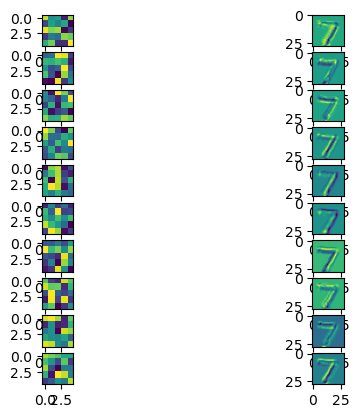

In [13]:
visualize()

# Predict Using Network

In [14]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [15]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_39515/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([7, 5, 9, 9, 9])

# First Test and Train

In [16]:
def test():
  network.eval()
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('Test accuracy: {:.0f}%\n'.format(100. * correct / len(test_loader.dataset)))

In [17]:
test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_39515/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 10%



In [18]:
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
def train():
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
      print('Train loss: {:.6f}'.format(loss.item()))

In [19]:
train()

Train loss: 2.297555


/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_39515/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.117498
Train loss: 1.289807
Train loss: 1.119677
Train loss: 0.746354
Train loss: 0.567339
Train loss: 0.549271
Train loss: 0.528016
Train loss: 0.406739
Train loss: 0.388556


# Train Network

In [20]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_39515/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.316366
Train loss: 1.959701
Train loss: 1.322953
Train loss: 0.828978
Train loss: 0.682005
Train loss: 0.825585
Train loss: 0.561133
Train loss: 0.745074
Train loss: 0.558611
Train loss: 0.577165
Test accuracy: 93%

Train loss: 0.620107
Train loss: 0.401150
Train loss: 0.333191
Train loss: 0.732413
Train loss: 0.455533
Train loss: 0.462394
Train loss: 0.301312
Train loss: 0.418249
Train loss: 0.510089
Train loss: 0.503155
Test accuracy: 96%

Train loss: 0.238901
Train loss: 0.290209
Train loss: 0.325644
Train loss: 0.422873
Train loss: 0.332621
Train loss: 0.301422
Train loss: 0.288018
Train loss: 0.385544
Train loss: 0.559627
Train loss: 0.329657
Test accuracy: 97%

Train loss: 0.321796
Train loss: 0.288507
Train loss: 0.158558
Train loss: 0.349075
Train loss: 0.242296
Train loss: 0.388345
Train loss: 0.218124
Train loss: 0.301274
Train loss: 0.364666
Train loss: 0.300266
Test accuracy: 97%

Train loss: 0.257661
Train loss: 0.142534
Train loss: 0.237271
Train loss: 0.317

# Inspect Network

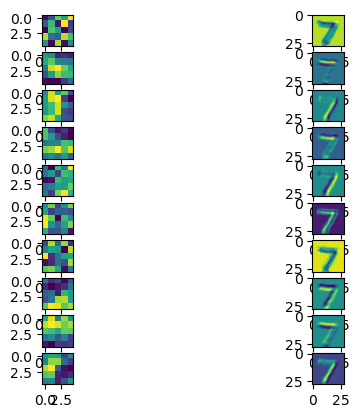

In [21]:
visualize()

In [22]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [23]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_39515/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([5, 0, 4, 1, 9])

# How Much Data?

- What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?
- How do the weights looks different when trained with 60,000 vs 600?

In [ ]:
torch.manual_seed(79)

In [29]:
# 60,000 images
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(60000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [30]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_39515/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.321011
Train loss: 1.836651
Train loss: 1.304768
Train loss: 0.973079
Train loss: 0.761782
Train loss: 0.650987
Train loss: 0.465616
Train loss: 0.537331
Train loss: 0.408602
Train loss: 0.370718
Test accuracy: 94%

Train loss: 0.635675
Train loss: 0.245829
Train loss: 0.365448
Train loss: 0.539583
Train loss: 0.425355
Train loss: 0.249538
Train loss: 0.499971
Train loss: 0.324585
Train loss: 0.349928
Train loss: 0.479330
Test accuracy: 96%

Train loss: 0.259316
Train loss: 0.356448
Train loss: 0.279921
Train loss: 0.146971
Train loss: 0.417029
Train loss: 0.240926
Train loss: 0.222733
Train loss: 0.280975
Train loss: 0.476727
Train loss: 0.364869
Test accuracy: 97%

Train loss: 0.229553
Train loss: 0.234054
Train loss: 0.225557
Train loss: 0.399984
Train loss: 0.437923
Train loss: 0.225142
Train loss: 0.440071
Train loss: 0.336973
Train loss: 0.525732
Train loss: 0.294312
Test accuracy: 97%

Train loss: 0.125921
Train loss: 0.191508
Train loss: 0.196854
Train loss: 0.296

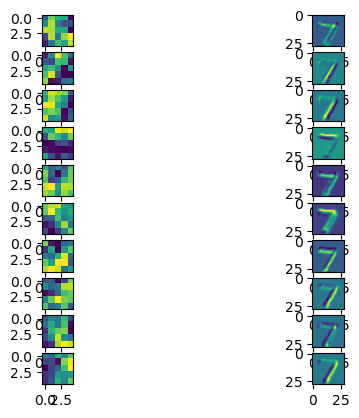

In [26]:
visualize()

In [31]:
# 30,000 images
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(30000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_39515/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.342200
Train loss: 2.232639
Train loss: 1.603766
Train loss: 0.862999
Train loss: 0.740852
Test accuracy: 90%

Train loss: 0.772532
Train loss: 0.656974
Train loss: 0.391202
Train loss: 0.585155
Train loss: 0.523569
Test accuracy: 94%

Train loss: 0.557550
Train loss: 0.323263
Train loss: 0.469871
Train loss: 0.519061
Train loss: 0.316684
Test accuracy: 96%

Train loss: 0.376901
Train loss: 0.272339
Train loss: 0.257381
Train loss: 0.462243
Train loss: 0.265899
Test accuracy: 96%

Train loss: 0.263126
Train loss: 0.288271
Train loss: 0.356980
Train loss: 0.380934
Train loss: 0.237203
Test accuracy: 97%



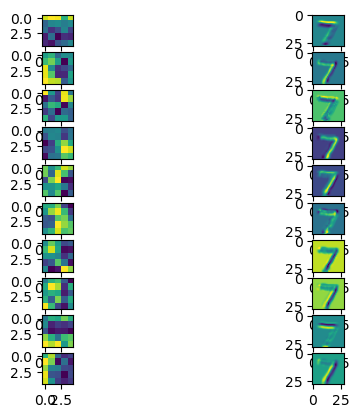

In [33]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()
visualize()

In [34]:
# 6,000 images 
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(6000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_39515/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.285715
Test accuracy: 55%

Train loss: 1.892578
Test accuracy: 82%

Train loss: 1.136094
Test accuracy: 89%

Train loss: 0.850112
Test accuracy: 90%

Train loss: 0.709606
Test accuracy: 91%



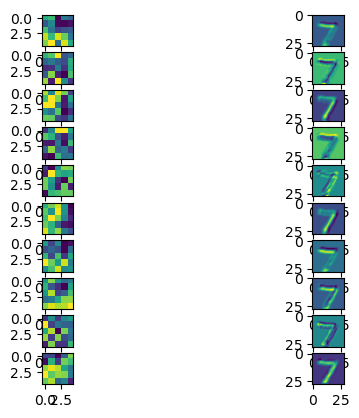

In [35]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()
visualize()

In [36]:
# 3,000 images
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(3000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_39515/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.280622
Test accuracy: 30%

Train loss: 2.218000
Test accuracy: 42%

Train loss: 2.049390
Test accuracy: 67%

Train loss: 1.654440
Test accuracy: 78%

Train loss: 1.398293
Test accuracy: 82%



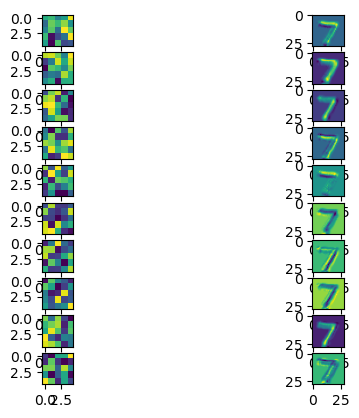

In [38]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()
visualize()

In [39]:
# 600 images
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(600))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_39515/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.317417
Test accuracy: 11%

Train loss: 2.305568
Test accuracy: 20%

Train loss: 2.273799
Test accuracy: 26%

Train loss: 2.246011
Test accuracy: 37%

Train loss: 2.257133
Test accuracy: 42%



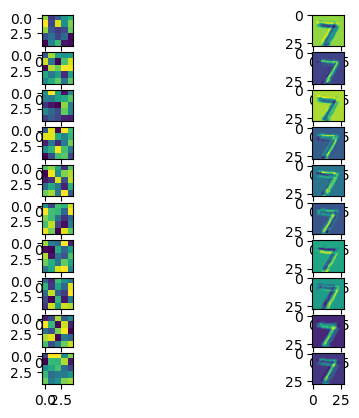

In [40]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()
visualize()

What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?
60,000: 98%
30,000: 97%
6,000: 91%
3,000: 82%
600: 42%

How do the weights looks different when trained with 60,000 vs 600?
- 60,000 has more organized colors on the grid while 600 is more random looking. 